TO DO
- Посмотреть можно ли разбить клиентов на группы по категориям товара/бренду/производителю
- Посмотреть завит ли цена от клиента
- Посмотреть на зависимость цены от промо и конкурентов

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
!ls -l data

total 41428
-rw-r--r-- 1 jupyter-v.pashentsev-2 jupyter-v.pashentsev-2   713801 Apr  1 10:41 canc_df.csv
-rw-r--r-- 1 jupyter-v.pashentsev-2 jupyter-v.pashentsev-2    28515 Apr  1 10:41 feedback.csv
-rw-r--r-- 1 jupyter-v.pashentsev-2 jupyter-v.pashentsev-2    22696 Apr  1 10:41 primer_batch.csv
-rw-r--r-- 1 jupyter-v.pashentsev-2 jupyter-v.pashentsev-2    26536 Apr  1 10:41 primer_posilki.csv
-rw-r--r-- 1 jupyter-v.pashentsev-2 jupyter-v.pashentsev-2    43347 Apr  1 10:41 promo_df.csv
-rw-r--r-- 1 jupyter-v.pashentsev-2 jupyter-v.pashentsev-2   312759 Apr  1 10:41 sales_plan.csv
-rw-r--r-- 1 jupyter-v.pashentsev-2 jupyter-v.pashentsev-2    74090 Apr  1 10:41 sample_1000.csv
-rw-r--r-- 1 jupyter-v.pashentsev-2 jupyter-v.pashentsev-2 39772262 Apr  1 10:41 transactions.csv
-rw-r--r-- 1 jupyter-v.pashentsev-2 jupyter-v.pashentsev-2  1407460 Apr  1 10:41 wholesale_trade_table.csv


In [3]:
df_transactions = pd.read_csv('data/transactions.csv')
df_sku_dict = pd.read_csv('data/sample_1000.csv')
df_promo = pd.read_csv('data/promo_df.csv')
df_canc = pd.read_csv('data/canc_df.csv')
df_sales_plan = pd.read_csv('data/sales_plan.csv')
df_wholesale_trade = pd.read_csv('data/wholesale_trade_table.csv')

In [4]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1334260 entries, 0 to 1334259
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   dates   1334260 non-null  object 
 1   SKU     1334260 non-null  int64  
 2   user    1334260 non-null  int64  
 3   price   1334260 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 40.7+ MB


###### Смортим общие статистики по полям

In [5]:
df_transactions['dates'] = pd.to_datetime(df_transactions['dates'])

In [6]:
(
    df_transactions
    .astype({'SKU': 'category', 'user': 'category'})
    .describe(include='all', datetime_is_numeric=True)
)

,dates,SKU,user,price
count,1334260,1334260.0,1334260.0,1.334260e+06
unique,NaN,1000.0,11062.0,NaN
top,NaN,38664.0,32994.0,NaN
freq,NaN,5106.0,490.0,NaN
mean,2019-03-31 03:56:58.513333504,NaN,NaN,2.315643e+03
min,2018-01-01 00:00:00,NaN,NaN,1.010000e+02
25%,2018-12-02 00:00:00,NaN,NaN,1.270000e+03
50%,2019-04-26 00:00:00,NaN,NaN,2.193000e+03
75%,2019-08-20 00:00:00,NaN,NaN,3.478000e+03
max,2019-11-30 00:00:00,NaN,NaN,4.649000e+03


1,4 млн записей за период с начала 2018 года по конец ноября 2019

###### Смотрим на поле SKU

In [7]:
df_transactions_sku_agg = (
    df_transactions
    .groupby('SKU', as_index=False)
    .agg(
        num_purchases=('dates', 'count'),
        num_users=('user', 'nunique'),
    )
)
df_transactions_sku_agg.head()

,SKU,num_purchases,num_users
0,10060,741,696
1,10121,263,256
2,10216,188,185
3,10230,1293,1158
4,10290,834,781


Может есть какие-то товары которые пользуются особой популярностью

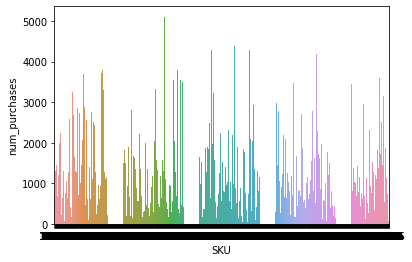

In [8]:
sns.barplot(x='SKU', y='num_purchases', data=df_transactions_sku_agg)

Таковых не отмечается, зато есть группы товаров которые покупают редко

Теперь посмотрим на популярность SKU среди клиентов

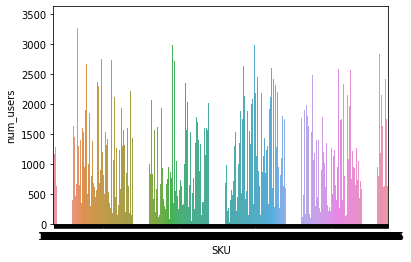

In [9]:
sns.barplot(x='SKU', y='num_users', data=df_transactions_sku_agg)

Опять видим что нет какого-то одного или двух супер популярных товаров, но есть редкие товары

###### Смотрим на поле user

In [10]:
df_transactions_user_agg = (
    df_transactions
    .groupby('user', as_index=False)
    .agg(
        num_purchase=('dates', 'count'),
        sku_count=('SKU', 'nunique'),
    )
)
df_transactions_user_agg.head()

,user,num_purchase,sku_count
0,10002,41,41
1,10003,449,331
2,10006,37,36
3,10008,45,44
4,10009,132,118


Может есть клиенты, с большим числом покупок

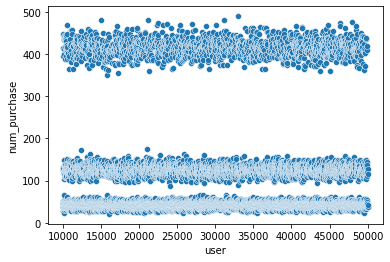

In [11]:
sns.scatterplot(x='user', y='num_purchase', data=df_transactions_user_agg)

Какие-то пользователи не выделяются

Посмотрим на разнообразие пользователей по покупкам

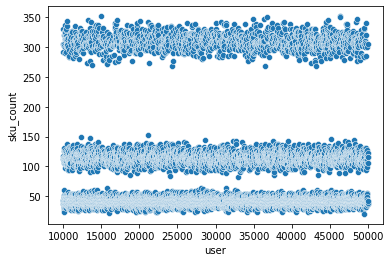

In [12]:
sns.scatterplot(x='user', y='sku_count', data=df_transactions_user_agg)

Можно заметить что у нас есть 3 группы покупателей (по кол-ву покупок)

In [13]:
mask1 = df_transactions_user_agg['num_purchase'].between(350, 500)
mask2 = df_transactions_user_agg['num_purchase'].between(75, 200)
mask3 = df_transactions_user_agg['num_purchase'].between(0, 74)

In [14]:
df_transactions['user'].nunique()

11062

In [15]:
mask1.sum() + mask2.sum() + mask3.sum()

11062

Проверим является ли группировка просто по кол-ву достаточной

In [16]:
df_transactions_user_agg.corr()

,user,num_purchase,sku_count
user,1.000000,0.009849,0.009344
num_purchase,0.009849,1.000000,0.997032
sku_count,0.009344,0.997032,1.000000


Видим что корреляция между кол-вом покупок и разнообразием корзины практически 1

###### Смотрим на цену

Посмотрим на распределение цены

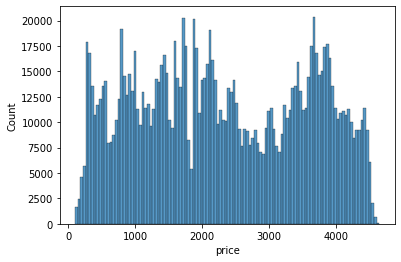

In [17]:
sns.histplot(x='price', data=df_transactions)

Можно сказать что цена равномерно распределена в определенном отрезке

Теперь посмотрим как цена зависит от даты

In [18]:
df_transactions_dates_agg = (
    df_transactions
    .groupby(['dates', 'SKU'], as_index=False)
    .agg(
        num_purchases=('SKU', 'count'),
        price=('price', 'mean'),
    )
)

Посмотрим на 30 случайных SKU

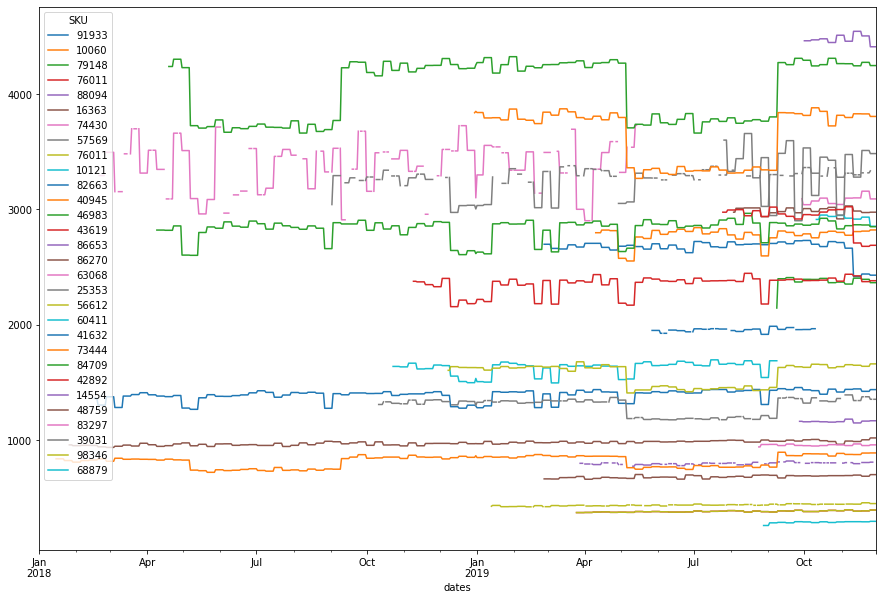

In [19]:
df_pivot = (
    df_transactions_dates_agg
    .pivot(index='dates', columns='SKU', values='price')
)
list_sku = df_transactions_dates_agg['SKU'].unique()
df_pivot.loc[:, np.random.choice(list_sku, size=30)].plot.line(figsize=(15, 10))

Видим сезонность как в задании 6

Посмотрим теперь зависит ли цена на один и тот же товар от пользователя

In [20]:
df_transactions_sku_agg.head()

,SKU,num_purchases,num_users
0,10060,741,696
1,10121,263,256
2,10216,188,185
3,10230,1293,1158
4,10290,834,781


Например 10121

In [21]:
df_tmp = (
    df_transactions
    .loc[df_transactions['SKU'] == 10230, :]
    .groupby(['dates', 'user'], as_index=False)
    .agg(price=('price', 'mean'))
    .pivot(index='dates', columns='user', values='price')
)
df_tmp.describe().T

,count,mean,std,min,25%,50%,75%,max
user,,,,,,,,
10011,1.0,1223.0,NaN,1223.0,1223.0,1223.0,1223.0,1223.0
10034,1.0,1238.0,NaN,1238.0,1238.0,1238.0,1238.0,1238.0
10059,1.0,1236.0,NaN,1236.0,1236.0,1236.0,1236.0,1236.0
10129,1.0,1223.0,NaN,1223.0,1223.0,1223.0,1223.0,1223.0
10155,1.0,1243.0,NaN,1243.0,1243.0,1243.0,1243.0,1243.0
...,...,...,...,...,...,...,...,...
49842,1.0,1211.0,NaN,1211.0,1211.0,1211.0,1211.0,1211.0
49858,1.0,1235.0,NaN,1235.0,1235.0,1235.0,1235.0,1235.0
49881,1.0,1223.0,NaN,1223.0,1223.0,1223.0,1223.0,1223.0
